In [2]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import ast

x = pd.read_csv('result/embedding-triplet-keys.csv')
x['0'] = x['0'].apply(lambda x: ast.literal_eval(x))

In [3]:
embedding = {}
for i in range(len(x)):
    r = x.iloc[i]
    embedding[r[0]] = r[1]

/var/folders/bw/64y3yr9n6v50fgm86wtx236c0000gn/T/ipykernel_16584/1491516759.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  embedding[r[0]] = r[1]


In [7]:
import numpy as np
from sklearn.cluster import DBSCAN
import pandas as pd

def prepare_embeddings(embedding_dict):
    keywords = list(embedding_dict.keys())
    embeddings = np.array([embedding_dict[k] for k in keywords])
    return keywords, embeddings

def cluster_embeddings(embeddings, eps=0.15):
        clustering = DBSCAN(eps=eps, min_samples=2, metric='cosine').fit(embeddings)
        print(clustering)
        return clustering.labels_

def get_cluster_representatives(clustered_df, embeddings):
    representatives = {}
    
    # Ignore noise points (cluster = -1)
    for cluster_id in clustered_df['cluster'].unique():
        if cluster_id == -1:
            continue
            
        # Get keywords and embeddings for this cluster
        cluster_mask = clustered_df['cluster'] == cluster_id
        cluster_keywords = clustered_df[cluster_mask]['keyword'].tolist()
        cluster_embeddings = embeddings[cluster_mask]
        
        # Calculate centroid
        centroid = np.mean(cluster_embeddings, axis=0)
        
        # Find closest word to centroid using cosine similarity
        similarities = np.dot(cluster_embeddings, centroid)
        similarities = similarities / (np.linalg.norm(cluster_embeddings, axis=1) * np.linalg.norm(centroid))
        representative_idx = np.argmax(similarities)
        
        representatives[int(cluster_id)] = {
            'representative': cluster_keywords[representative_idx],
            'members': cluster_keywords
        }
    
    return representatives

# Modify your original code
def process_keywords(embedding_dict):
    keywords, embeddings = prepare_embeddings(embedding_dict)
    labels = cluster_embeddings(embeddings)
    df = pd.DataFrame({'keyword': keywords, 'cluster': labels})
    
    representatives = get_cluster_representatives(df, embeddings)
    
    return df, representatives

clustered, cluster_representatives = process_keywords(embedding)

for cluster_id, info in cluster_representatives.items():
    print(f"\nCluster {cluster_id}:")
    print(f"Representative: {info['representative']}")
    print(f"All members: {', '.join(info['members'])}")

# print(f"Total keywords: {len(clustered)}")
# print(f"Number of clusters: {len(clustered['cluster'].unique()) - 1}")
# print(f"Unclustered keywords: {len(clustered[clustered['cluster'] == -1])}")

# for i in clustered['cluster'].unique():
#     print(f"Cluster {i}:")
#     print(clustered[clustered['cluster'] == i]['keyword'].tolist())
#     print()

DBSCAN(eps=0.15, metric='cosine', min_samples=2)

Cluster 0:
Representative: attitudes toward ai
All members: attitudes toward ai, attitudes towards ai

Cluster 1:
Representative: human-ai interaction
All members: human-ai and ai-ai interactions, human-ai collaboration, human-ai dynamics, human-ai communication, notions of human-ai interaction, interactive human-ai collaboration, human-ai collaboration quality, human-ai interaction

Cluster 2:
Representative: ai system
All members: ai methods, ai systems, ai system, ai models

Cluster 3:
Representative: user trust in ai
All members: trust in ai systems, user trust in ai classifications, user trust in ai systems, trust in ai, trust levels in ai systems, human trust in ai models, user trust in ai, appropriate human trust in ai, user trust in ai features, trust in ai-integrated systems

Cluster 4:
Representative: user behavior patterns
All members: user behavior, user behavior patterns

Cluster 5:
Representative: ai explanations that aid 

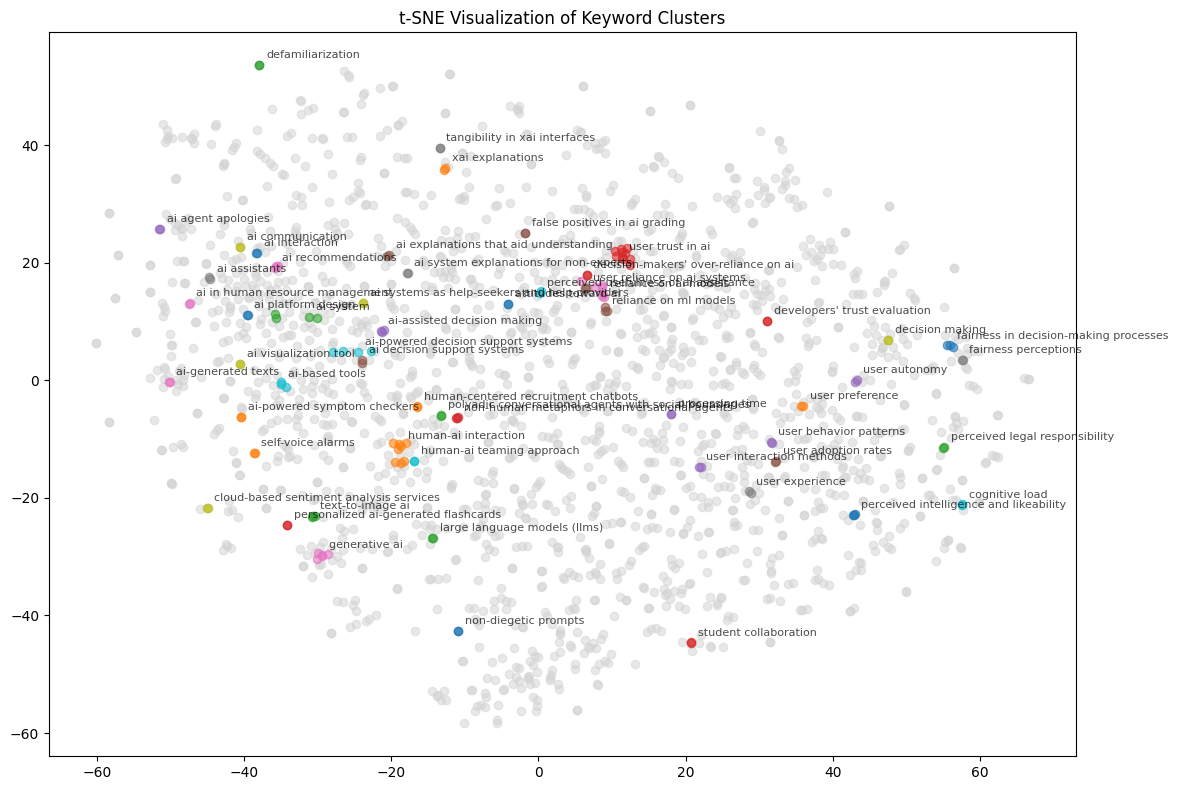

In [8]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

res = set([cluster_representatives[k]['representative'] for k in cluster_representatives])

def visualize_clusters(df, embeddings, perplexity=30, random_state=42):
    # Create t-SNE embedding
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=random_state)
    embeddings_2d = tsne.fit_transform(embeddings)
    
    # Add t-SNE coordinates to dataframe
    df_viz = df.copy()
    df_viz['x'] = embeddings_2d[:, 0]
    df_viz['y'] = embeddings_2d[:, 1]
    
    # Set up the plot
    plt.figure(figsize=(12, 8))
    
    # Create color palette for clusters
    n_clusters = len(df_viz['cluster'].unique())
    palette = sns.color_palette("husl", n_clusters)
    
    # Plot noise points first
    noise_mask = df_viz['cluster'] == -1
    plt.scatter(df_viz[noise_mask]['x'], 
                df_viz[noise_mask]['y'], 
                c='lightgray',
                alpha=0.5,
                label='Noise')
    
    # Plot clusters
    for cluster_id in sorted(df_viz['cluster'].unique()):
        if cluster_id == -1:
            continue
            
        mask = df_viz['cluster'] == cluster_id
        plt.scatter(df_viz[mask]['x'], 
                   df_viz[mask]['y'], 
                   label=f'Cluster {cluster_id}',
                   alpha=0.6)
    
    # # Add labels for some points (optional)
    for idx, row in df_viz.iterrows():
        if row['cluster'] != -1 and row['keyword'] in res:  # Only label clustered points
            plt.annotate(row['keyword'], 
                        (row['x'], row['y']),
                        xytext=(5, 5),
                        textcoords='offset points',
                        fontsize=8,
                        alpha=0.7)
    
    plt.title('t-SNE Visualization of Keyword Clusters')
    # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    
    return plt.gcf()

keywords, x = prepare_embeddings(embedding)
fig = visualize_clusters(clustered, x)

In [26]:
clustered['representative'] = ''

for i in range(len(clustered)):
    r = clustered.iloc[i]
    c = int(r['cluster'])
    clustered.iloc[i, clustered.columns.get_loc('representative')] = cluster_representatives[c]['representative'] if c != -1 else r['keyword']
    
clustered.to_csv('result/merged-triplets-keys.csv', index=False)